<a href="https://colab.research.google.com/github/amfolity/interpretability/blob/main/SoftmaxProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def adaptive_temperature_softmax(logits):
  original_probs = jax.nn.softmax(logits)
  poly_fit = jnp.array([-0.037, 0.481, -2.3, 4.917, -1.791]) # see Figure 5
  entropy = jnp.sum(-original_probs * jnp.log(original_probs + 1e-9), axis=-1, keepdims=True) # compute the Shannon entropy
  beta = jnp.where( # beta = 1 / theta
                   entropy > 0.5, # don’t overcorrect low-entropy heads
  jnp.maximum(jnp.polyval(poly_fit, entropy), 1.0), # never increase entropy
  1.0)
return jax.nn.softmax(logits * beta)

hi


In [116]:
import transformers

In [113]:
model_name = 'google/gemma-2-2b-it'


In [114]:
from huggingface_hub import login
login()

In [117]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [119]:
model_Gemma2b = transformers.AutoModelForCausalLM.from_pretrained(model_name)

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

In [ ]:
for param in model.parameters():
  param.requires_grad = False

In [ ]:
model_Gemma2b.gradient_checkpointing_enable()
model_Gemma2b.enable_input_require_grads()

In [ ]:
import torch
prompt = ''

In [ ]:
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False)
for i in range(10):
  next_token = model(**batch).logits[0, -1].argmax(-1).reshape(1, 1)
  batch['input_ids'] = torch.cat([batch['input_ids'], next_token], dim=-1)
  batch['attention_mask'] = torch.cat([batch['attention_mask'], torch.ones_like(next_token)], dim=-1)

print(tokenizer.decode(batch['input_ids'][0]))

NameError: name 'tokenizer' is not defined

In [ ]:
batch

{'input_ids': tensor([[     2, 235280,   4320,   8426,  25341]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
import jax.numpy as jnp
from flax import linen as nn
from typing import Callable
class Model(nn.Module):
  def __init__(self, n_classes, n_feats, activation):
    super().__init__()
  n_classes = n_classes # 10
  n_feats = n_feats # 128
  activation = nn.gelu


def __call__(self, x, q):
  x = nn.Dense(features=self.n_feats)(x)
  x = self.activation(x)
  x = nn.Dense(features=self.n_feats)(x)
  x = self.activation(x)
  q = nn.Dense(features=self.n_feats)(q)
  q = self.activation(q)
  q = nn.Dense(features=self.n_feats)(q)
  x = nn.MultiHeadDotProductAttention(
  num_heads=1,
  qkv_features=self.n_feats)(
  inputs_q=q,
  inputs_kv=x)
  x = nn.Dense(features=self.n_feats)(jnp.squeeze(x, -2))
  x = self.activation(x)
  x = nn.Dense(features=self.n_classes)(x)
  return x

NameError: name 'n_classes' is not defined

In [12]:
import functools

def f(a,b=4):
  '''
  ya krivedko
  '''
  return a*10 + b

ff = functools.partial(f, b=5)

ff(a=7)

75

In [98]:
from copy import deepcopy
import math
weights_log = []
weights_log_model_softmax = []

# Efficient implementation equivalent to the following:
def custom_scaled_dot_product_attention(query, key, value, attn_mask=None, dropout_p=0.0,
        is_causal=False, scale=None, enable_gqa=False, logging=False, softmax = torch.softmax) -> torch.Tensor:
    L, S = query.size(-2), key.size(-2)
    scale_factor = 1 / math.sqrt(query.size(-1)) if scale is None else scale
    attn_bias = torch.zeros(L, S, dtype=query.dtype, device=query.device)
    if is_causal:
        assert attn_mask is None
        temp_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0)
        attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
        attn_bias.to(query.dtype)

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_bias.masked_fill_(attn_mask.logical_not(), float("-inf"))
        else:
            attn_bias = attn_mask + attn_bias

    if enable_gqa:
        key = key.repeat_interleave(query.size(-3)//key.size(-3), -3)
        value = value.repeat_interleave(query.size(-3)//value.size(-3), -3)

    attn_weight = query @ key.transpose(-2, -1) * scale_factor
    attn_weight += attn_bias
    attn_weight = softmax(attn_weight, dim=-1)
    attn_weight = torch.dropout(attn_weight, dropout_p, train=True)
    if logging:
      if softmax == torch.softmax:
        weights_log.append(attn_weight.detach().cpu().numpy())
      else:
        weights_log_model_softmax.append(attn_weight.detach().cpu().numpy())
    return attn_weight @ value

In [99]:
import torch
class Model(nn.Module):
  def __init__(self, n_classes=10, n_feats=128, activation=nn.GELU()):
    super().__init__()
    self.n_classes = n_classes
    self.n_feats = n_feats
    self.activation = activation
    self.fc1 = nn.Linear(in_features=self.n_classes + 1, out_features=self.n_feats)
    self.fc2 = nn.Linear(in_features=self.n_feats, out_features=self.n_feats)
    self.fc3 = nn.Linear(in_features=self.n_feats, out_features=self.n_feats)
    self.fc4 = nn.Linear(in_features=self.n_feats, out_features=self.n_feats)
    self.q_proj = nn.Linear(in_features=self.n_feats, out_features=self.n_feats, bias=False)
    self.k_proj = nn.Linear(in_features=self.n_feats, out_features=self.n_feats, bias=False)
    self.v_proj = nn.Linear(in_features=self.n_feats, out_features=self.n_feats, bias=False)

    self.fc5 = nn.Linear(in_features=self.n_feats, out_features=self.n_feats)
    self.fc6 = nn.Linear(in_features=self.n_feats, out_features=self.n_classes)
    self.attention_function = F.scaled_dot_product_attention


  def forward(self, x, q):
    x = self.activation(self.fc1(x))
    x = self.activation(self.fc2(x))
    q = self.activation(self.fc3(q))
    q = self.fc4(q)
    k = self.k_proj(x)
    q = self.q_proj(q)
    v = self.v_proj(x)

    #print(q.shape)
    ##print(x.unsqueeze(-3).shape)
    #print(x.shape)

    x = self.attention_function(q.unsqueeze(-3), k.unsqueeze(-3), v.unsqueeze(-3), is_causal=False)

    #print(x.shape)
    #print(x.squeeze(-2).squeeze(-2).shape)

    x = self.fc6(self.activation(self.fc5(x.squeeze(-2).squeeze(-2))))

    #print(x.shape)
    return x

  def torch_polyval(self, coeffs, x):
    """
    Evaluate a polynomial at points x using PyTorch.
    """
    result = torch.zeros_like(x, dtype=torch.float32)
    for coeff in coeffs:
        result = result * x + coeff
    return result

  def softmax(self, attn_weight, dim=-1):
    original_probs = torch.softmax(attn_weight, dim=dim)

    poly_fit = torch.tensor([-0.037, 0.481, -2.3, 4.917, -1.791])
    entropy = torch.sum(-original_probs * torch.log(original_probs + 1e-9), dim=-1, keepdim=True)
    #print(self.torch_polyval(poly_fit, entropy))
    beta = torch.where(entropy > 0.5, torch.maximum(self.torch_polyval(poly_fit, entropy), torch.tensor(1.0)), torch.tensor(1.0))
    return torch.softmax(attn_weight * beta, dim=-1)
    #return torch.softmax(attn_weight, dim=-1)

In [100]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.float32 if device=='cuda' else torch.float32

In [101]:
batch_size = 128  # Number of samples in the batch
input_dim = 128   # Number of features per sample
n = 16
num_classes = 10
# Generate a batch of random values in the range [0,1)

rho = torch.rand(batch_size, n, 1)
cla = torch.randint(0, num_classes, (batch_size, n))
one_hot = torch.zeros(batch_size, n, num_classes)
one_hot.scatter_(2, cla.unsqueeze(2), 1)
X = torch.cat([rho, one_hot], dim=-1)
Y = cla.take(torch.argmax(rho.squeeze(-1), dim=-1))
q = torch.rand(batch_size, 1, input_dim)

#q =  torch.rand(1, input_dim)
model = Model(n_classes=num_classes, n_feats=input_dim, activation=nn.GELU())
#model(X,q)

In [102]:
model.attention_function = functools.partial(custom_scaled_dot_product_attention, logging=False, softmax=model.softmax)

In [103]:
model.to(device).to(dtype)

Model(
  (activation): GELU(approximate='none')
  (fc1): Linear(in_features=11, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
  (q_proj): Linear(in_features=128, out_features=128, bias=False)
  (k_proj): Linear(in_features=128, out_features=128, bias=False)
  (v_proj): Linear(in_features=128, out_features=128, bias=False)
  (fc5): Linear(in_features=128, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=10, bias=True)
)

In [104]:
model.fc3.weight

Parameter containing:
tensor([[-0.0169, -0.0268,  0.0066,  ...,  0.0081, -0.0585,  0.0271],
        [ 0.0157, -0.0509,  0.0869,  ..., -0.0514, -0.0671,  0.0023],
        [-0.0150,  0.0050, -0.0124,  ..., -0.0052,  0.0234,  0.0799],
        ...,
        [ 0.0274,  0.0882,  0.0236,  ...,  0.0466,  0.0491, -0.0769],
        [-0.0395, -0.0654, -0.0191,  ...,  0.0314,  0.0254, -0.0811],
        [-0.0511, -0.0421,  0.0203,  ..., -0.0436,  0.0398, -0.0792]],
       device='cuda:0', requires_grad=True)

In [105]:
model.fc3.weight

Parameter containing:
tensor([[-0.0169, -0.0268,  0.0066,  ...,  0.0081, -0.0585,  0.0271],
        [ 0.0157, -0.0509,  0.0869,  ..., -0.0514, -0.0671,  0.0023],
        [-0.0150,  0.0050, -0.0124,  ..., -0.0052,  0.0234,  0.0799],
        ...,
        [ 0.0274,  0.0882,  0.0236,  ...,  0.0466,  0.0491, -0.0769],
        [-0.0395, -0.0654, -0.0191,  ...,  0.0314,  0.0254, -0.0811],
        [-0.0511, -0.0421,  0.0203,  ..., -0.0436,  0.0398, -0.0792]],
       device='cuda:0', requires_grad=True)

In [106]:
torch.max(model.fc3.weight)

tensor(0.0884, device='cuda:0', grad_fn=<MaxBackward1>)

In [107]:
import random
import tqdm
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0003)
#opt = torch.optim.Adam(model.parameters(), lr=0.01)
q = torch.rand(1, 1, input_dim, device=device, dtype=dtype).tile((batch_size, 1, 1))


for epoch in tqdm.trange(100000):
  n = random.randint(5, 16)
  rho = torch.rand(batch_size, n, 1, device=device, dtype=dtype)
  #rhomax = torch.max(rho, dim = -2, keepdims=True)
  #rho[rho != rhomax] *= 0.8

  cla = torch.randint(0, num_classes, (batch_size, n), device=device)
  one_hot = torch.zeros(batch_size, n, num_classes, device=device, dtype=dtype)
  one_hot.scatter_(2, cla.unsqueeze(2), 1)
  X = torch.cat([rho, one_hot], dim=-1)
  Y = cla.take_along_dim(torch.argmax(rho.squeeze(-1), dim=-1).unsqueeze(-1), dim=-1).squeeze(-1)
  #q = torch.rand(batch_size, 1, input_dim, device=device, dtype=dtype)
  opt.zero_grad()
  outputs = model(X,q) ## what is X and q here, do we need to generate each tim
  loss = F.cross_entropy(outputs, Y)
  if epoch % 1000 == 0:
    print("loss is {}".format(loss.item()))
  loss.backward()
  opt.step()

  0%|          | 15/100000 [00:00<11:39, 143.04it/s]

loss is 2.308889627456665


  1%|          | 1041/100000 [00:05<07:09, 230.29it/s]

loss is 0.03771819546818733


  2%|▏         | 2042/100000 [00:09<07:11, 227.15it/s]

loss is 0.10748647153377533


  3%|▎         | 3028/100000 [00:14<07:25, 217.79it/s]

loss is 0.06625720113515854


  4%|▍         | 4022/100000 [00:18<07:08, 224.20it/s]

loss is 0.05628462880849838


  5%|▌         | 5025/100000 [00:22<06:52, 230.45it/s]

loss is 0.05659038573503494


  6%|▌         | 6043/100000 [00:27<06:52, 227.89it/s]

loss is 0.06713078916072845


  7%|▋         | 7042/100000 [00:32<06:50, 226.21it/s]

loss is 0.017114244401454926


  8%|▊         | 8031/100000 [00:36<08:16, 185.36it/s]

loss is 0.05478568375110626


  9%|▉         | 9041/100000 [00:41<06:30, 232.74it/s]

loss is 0.041519779711961746


 10%|█         | 10047/100000 [00:45<06:26, 232.50it/s]

loss is 0.1192680075764656


 11%|█         | 11042/100000 [00:50<06:37, 224.01it/s]

loss is 0.03691156208515167


 12%|█▏        | 12027/100000 [00:55<06:30, 225.52it/s]

loss is 0.03205862641334534


 13%|█▎        | 13043/100000 [00:59<06:26, 224.90it/s]

loss is 0.008497031405568123


 14%|█▍        | 14037/100000 [01:04<06:14, 229.67it/s]

loss is 0.021929048001766205


 15%|█▌        | 15043/100000 [01:09<06:22, 222.26it/s]

loss is 0.004309475421905518


 16%|█▌        | 16038/100000 [01:14<07:19, 191.18it/s]

loss is 0.033903803676366806


 17%|█▋        | 17031/100000 [01:18<06:07, 225.65it/s]

loss is 0.034348729997873306


 18%|█▊        | 18032/100000 [01:22<05:58, 228.52it/s]

loss is 0.010544213466346264


 19%|█▉        | 19033/100000 [01:27<05:59, 225.01it/s]

loss is 0.0405091792345047


 20%|██        | 20030/100000 [01:32<05:54, 225.87it/s]

loss is 0.056754808872938156


 21%|██        | 21023/100000 [01:36<07:56, 165.82it/s]

loss is 0.06248518452048302


 22%|██▏       | 22042/100000 [01:41<05:31, 234.86it/s]

loss is 0.02830650471150875


 23%|██▎       | 23023/100000 [01:45<05:32, 231.81it/s]

loss is 0.01307023223489523


 24%|██▍       | 24034/100000 [01:50<05:40, 223.25it/s]

loss is 0.0569021962583065


 25%|██▌       | 25034/100000 [01:55<05:29, 227.40it/s]

loss is 0.010495197027921677


 26%|██▌       | 26035/100000 [01:59<05:25, 227.40it/s]

loss is 0.07598474621772766


 27%|██▋       | 27030/100000 [02:04<05:24, 224.73it/s]

loss is 0.0013166257413104177


 28%|██▊       | 28044/100000 [02:08<05:17, 226.54it/s]

loss is 0.04389187693595886


 29%|██▉       | 29031/100000 [02:13<07:17, 162.16it/s]

loss is 0.005055460147559643


 30%|███       | 30030/100000 [02:18<05:08, 226.65it/s]

loss is 0.006121378391981125


 31%|███       | 31027/100000 [02:22<04:54, 234.34it/s]

loss is 0.017970584332942963


 32%|███▏      | 32034/100000 [02:27<04:51, 233.15it/s]

loss is 0.021827392280101776


 33%|███▎      | 33031/100000 [02:31<04:50, 230.53it/s]

loss is 0.01562950573861599


 34%|███▍      | 34025/100000 [02:36<05:32, 198.18it/s]

loss is 0.07326661050319672


 35%|███▌      | 35040/100000 [02:41<04:37, 234.48it/s]

loss is 0.004068044945597649


 36%|███▌      | 36021/100000 [02:45<04:36, 231.32it/s]

loss is 0.027485614642500877


 37%|███▋      | 37036/100000 [02:50<05:06, 205.35it/s]

loss is 0.03892122209072113


 38%|███▊      | 38031/100000 [02:54<04:36, 224.02it/s]

loss is 0.08716575801372528


 39%|███▉      | 39031/100000 [02:59<04:24, 230.15it/s]

loss is 0.001252213609404862


 40%|████      | 40031/100000 [03:04<04:35, 217.80it/s]

loss is 0.0015234217280521989


 41%|████      | 41026/100000 [03:08<04:18, 227.92it/s]

loss is 0.011466540396213531


 42%|████▏     | 42036/100000 [03:13<05:24, 178.38it/s]

loss is 0.003016512608155608


 43%|████▎     | 43026/100000 [03:17<04:11, 226.20it/s]

loss is 0.013194551691412926


 44%|████▍     | 44030/100000 [03:22<04:03, 230.11it/s]

loss is 0.003555129747837782


 45%|████▌     | 45038/100000 [03:27<04:06, 222.79it/s]

loss is 0.007680055219680071


 46%|████▌     | 46035/100000 [03:31<04:00, 224.37it/s]

loss is 0.012702830135822296


 47%|████▋     | 47028/100000 [03:35<03:47, 232.92it/s]

loss is 0.014387783594429493


 48%|████▊     | 48044/100000 [03:40<03:43, 232.25it/s]

loss is 0.02516770176589489


 49%|████▉     | 49026/100000 [03:45<03:40, 231.57it/s]

loss is 0.0015218076296150684


 50%|█████     | 50018/100000 [03:49<04:54, 169.70it/s]

loss is 0.05673345923423767


 51%|█████     | 51026/100000 [03:54<03:33, 229.28it/s]

loss is 0.010558082722127438


 52%|█████▏    | 52030/100000 [03:58<03:27, 231.01it/s]

loss is 0.0044960398226976395


 53%|█████▎    | 53029/100000 [04:03<03:22, 231.51it/s]

loss is 0.02690611593425274


 54%|█████▍    | 54033/100000 [04:08<03:23, 225.66it/s]

loss is 0.02389501966536045


 55%|█████▌    | 55032/100000 [04:12<03:32, 211.23it/s]

loss is 0.0037354878149926662


 56%|█████▌    | 56028/100000 [04:17<03:17, 222.17it/s]

loss is 0.01443740725517273


 57%|█████▋    | 57031/100000 [04:21<03:06, 230.19it/s]

loss is 0.04063846915960312


 58%|█████▊    | 58045/100000 [04:26<03:19, 210.03it/s]

loss is 0.003912521526217461


 59%|█████▉    | 59044/100000 [04:31<02:58, 229.76it/s]

loss is 0.034995514899492264


 60%|██████    | 60036/100000 [04:35<02:59, 223.09it/s]

loss is 0.011178236454725266


 61%|██████    | 61031/100000 [04:40<02:51, 227.59it/s]

loss is 0.007221814710646868


 62%|██████▏   | 61755/100000 [04:43<02:55, 217.65it/s]


KeyboardInterrupt: 

In [ ]:
weights_log = []
max_rho_idcs = []
model.attention_function = functools.partial(custom_scaled_dot_product_attention, logging=True, softmax=torch.softmax)

In [108]:
weights_log_model_softmax = []
max_rho_idcs_model_softmax = []
model.attention_function = functools.partial(custom_scaled_dot_product_attention, logging=True, softmax=model.softmax)

In [109]:
for pw2 in range(4, 15, 1):
  n = 1 << pw2
  rho = torch.rand(batch_size, n, 1, device=device, dtype=dtype)
  idcs = torch.argsort(rho.squeeze(-1), dim=-1)[:, -16:]
  max_rho_idcs.append(idcs.cpu().numpy())

  cla = torch.randint(0, num_classes, (batch_size, n), device=device)
  one_hot = torch.zeros(batch_size, n, num_classes, device=device, dtype=dtype)
  one_hot.scatter_(2, cla.unsqueeze(2), 1)
  X = torch.cat([rho, one_hot], dim=-1)
  Y = cla.take_along_dim(torch.argmax(rho.squeeze(-1), dim=-1).unsqueeze(-1), dim=-1).squeeze(-1)
  #q = torch.rand(batch_size, 1, input_dim, device=device, dtype=dtype)
  outputs = model(X,q) ## what is X and q here, do we need to generate each tim
  loss = F.cross_entropy(outputs, Y)
  print("loss is {}".format(loss.item()))


NameError: name 'max_rho_idcs' is not defined

In [110]:
for pw2 in range(4, 15, 1):
  n = 1 << pw2
  rho = torch.rand(batch_size, n, 1, device=device, dtype=dtype)
  idcs = torch.argsort(rho.squeeze(-1), dim=-1)[:, -16:]
  max_rho_idcs_model_softmax.append(idcs.cpu().numpy())

  cla = torch.randint(0, num_classes, (batch_size, n), device=device)
  one_hot = torch.zeros(batch_size, n, num_classes, device=device, dtype=dtype)
  one_hot.scatter_(2, cla.unsqueeze(2), 1)
  X = torch.cat([rho, one_hot], dim=-1)
  Y = cla.take_along_dim(torch.argmax(rho.squeeze(-1), dim=-1).unsqueeze(-1), dim=-1).squeeze(-1)
  #q = torch.rand(batch_size, 1, input_dim, device=device, dtype=dtype)
  outputs = model(X,q) ## what is X and q here, do we need to generate each tim
  loss = F.cross_entropy(outputs, Y)
  print("loss is {}".format(loss.item()))

loss is 0.001236164360307157
loss is 0.024621352553367615
loss is 0.07811198383569717
loss is 0.13642087578773499
loss is 0.20224051177501678
loss is 0.7640484571456909
loss is 1.2516484260559082
loss is 2.2037622928619385
loss is 2.5346004962921143
loss is 3.080138921737671
loss is 3.361144781112671


In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

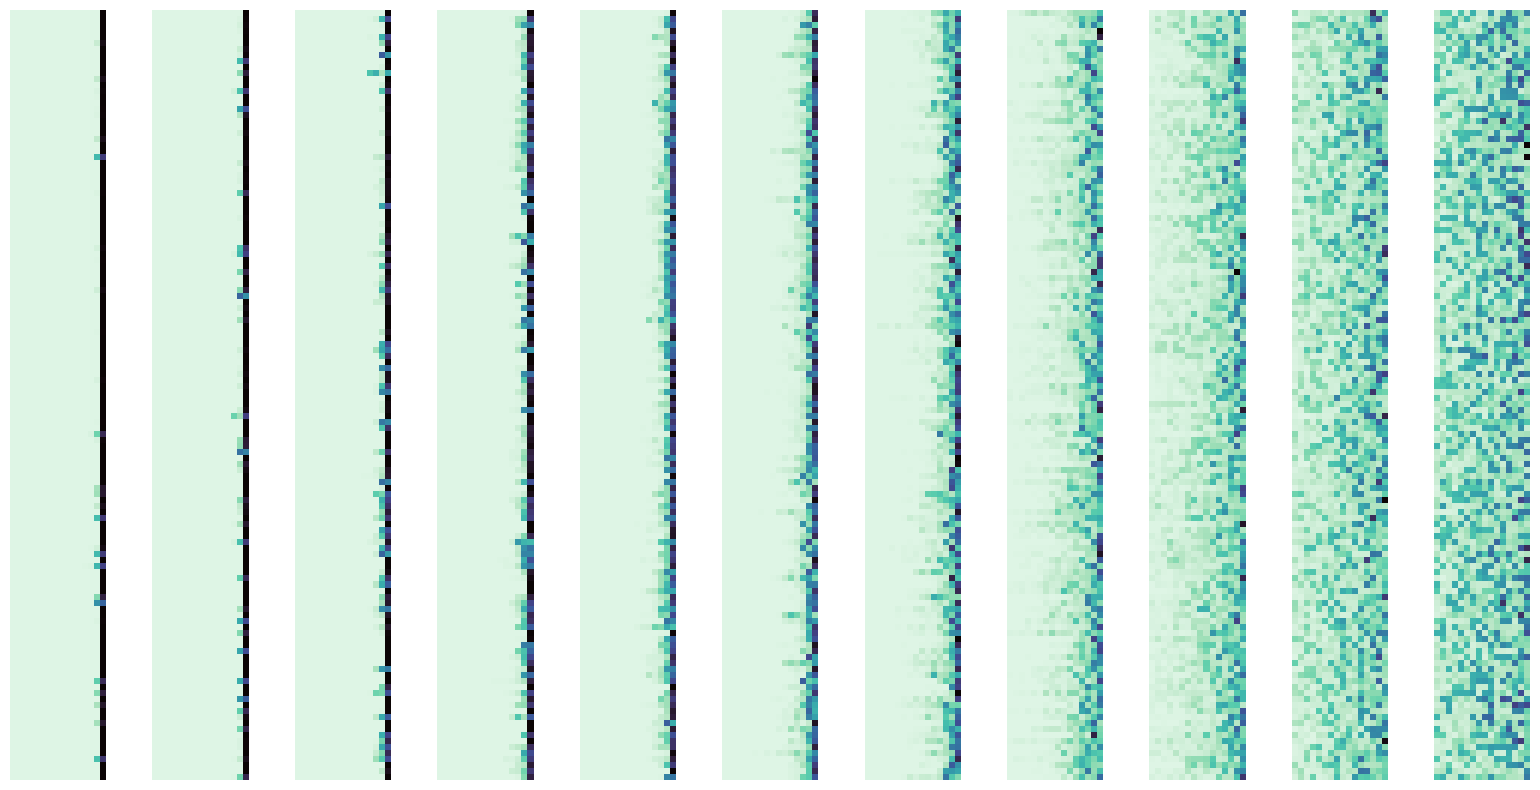

In [111]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(1, 11, figsize=(16, 8))

# Plot each heatmap
for i, ax in enumerate(axes.flat):
    data = weights_log_model_softmax[i].squeeze()
    #np.sort(data)
    #data = np.sort(data)[:, -16:]
    data = np.take_along_axis(data, max_rho_idcs_model_softmax[i], -1)
    sns.heatmap(-data, ax=ax, cbar=False, square=True, cmap='mako')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


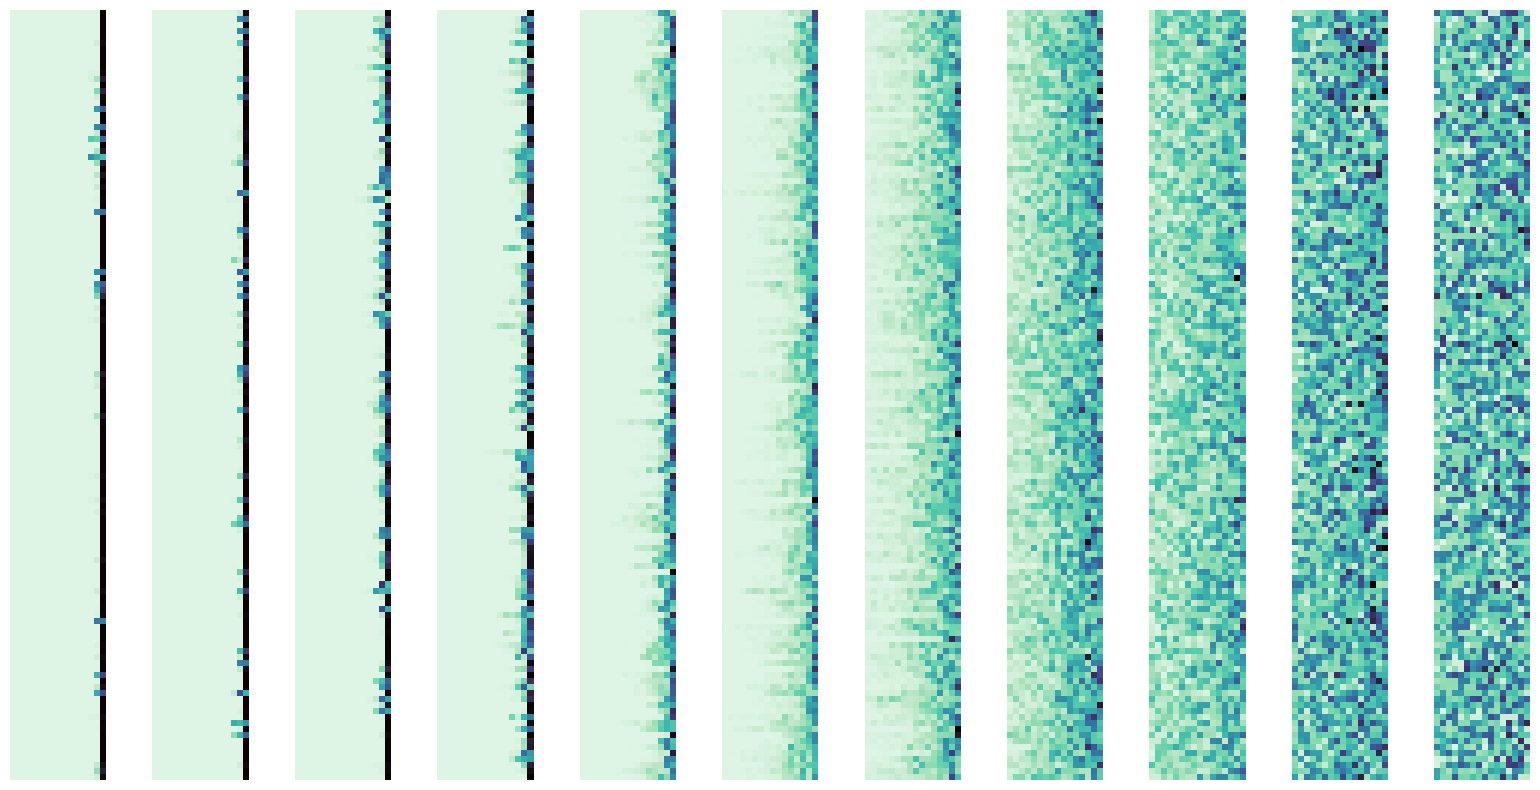

In [147]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(1, 11, figsize=(16, 8))

# Plot each heatmap
for i, ax in enumerate(axes.flat):
    data = weights_log[i].squeeze()
    #np.sort(data)
    #data = np.sort(data)[:, -16:]
    data = np.take_along_axis(data, max_rho_idcs[i], -1)
    sns.heatmap(-data, ax=ax, cbar=False, square=True, cmap='mako')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


In [60]:
idx = 101
print(X[idx])
print(Y[idx])

tensor([[0.6077, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000],
        [0.4161, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000],
        [0.7344, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.8621, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.7682, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.7123, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000],
        [0.0200, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000],
        [0.5742, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000]], device='cuda:0')
tensor(1, device='cuda:0')


In [26]:
print(rho[idx])
print(cla[idx])

tensor([[0.5275],
        [0.1077],
        [0.9811],
        [0.0509],
        [0.9447],
        [0.3840],
        [0.1458],
        [0.2467]], device='cuda:0')
tensor([0, 3, 0, 4, 4, 4, 1, 6], device='cuda:0')


In [29]:
rho.shape

torch.Size([128, 8, 1])

In [40]:
torch.argmax(rho.squeeze(-1), dim=-1).unsqueeze(-1)

tensor([[2],
        [2],
        [2],
        [2],
        [0],
        [0],
        [0],
        [4],
        [4],
        [5],
        [6],
        [2],
        [7],
        [0],
        [5],
        [3],
        [3],
        [3],
        [4],
        [4],
        [2],
        [5],
        [5],
        [4],
        [5],
        [4],
        [1],
        [1],
        [0],
        [4],
        [0],
        [5],
        [7],
        [7],
        [7],
        [6],
        [6],
        [5],
        [1],
        [5],
        [3],
        [4],
        [7],
        [5],
        [2],
        [0],
        [1],
        [4],
        [2],
        [3],
        [0],
        [3],
        [2],
        [5],
        [1],
        [2],
        [5],
        [6],
        [7],
        [7],
        [3],
        [0],
        [7],
        [4],
        [2],
        [6],
        [6],
        [5],
        [3],
        [3],
        [6],
        [1],
        [0],
        [5],
        [7],
        [0],
        [7],

In [46]:
cla.take_along_dim(torch.argmax(rho.squeeze(-1), dim=-1).unsqueeze(-1), dim=-1).squeeze(-1)

tensor([6, 8, 4, 0, 6, 1, 6, 9, 2, 7, 1, 3, 8, 0, 2, 0, 4, 6, 1, 7, 8, 0, 1, 2,
        3, 9, 8, 7, 0, 9, 4, 0, 0, 5, 3, 1, 5, 5, 6, 1, 9, 1, 2, 3, 9, 9, 5, 7,
        1, 8, 4, 2, 1, 9, 6, 4, 3, 8, 6, 2, 0, 8, 6, 1, 6, 5, 3, 4, 2, 7, 3, 2,
        0, 0, 6, 6, 4, 0, 4, 8, 6, 9, 3, 0, 8, 4, 5, 7, 9, 0, 2, 5, 3, 7, 7, 8,
        0, 3, 3, 5, 4, 9, 9, 8, 5, 9, 8, 4, 8, 7, 5, 3, 7, 4, 4, 9, 0, 1, 6, 4,
        4, 8, 0, 0, 8, 9, 0, 6], device='cuda:0')

In [ ]:
model(X,q)[6]

torch.Size([128, 1, 128])
torch.Size([128, 1, 7, 128])
torch.Size([128, 7, 128])
torch.Size([128, 1, 1, 128])
torch.Size([128, 128])
torch.Size([128, 10])


tensor([ 0.0326,  0.1267,  0.0637,  0.0893,  0.0409, -0.1043,  0.0812, -0.0475,
        -0.0947,  0.0971], device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
cla[0]

tensor([6, 7, 1, 0, 6, 8, 9, 0, 0, 4, 5, 0, 5, 3, 1, 8], device='cuda:0')

In [ ]:
torch.argmax(rho.squeeze(-1), dim=-1)

tensor([ 8,  3, 14,  6, 11, 10, 15,  4,  8, 10, 12,  1,  9,  0, 11, 13,  2,  9,
         6, 11,  9, 11,  2, 13, 15,  0,  9,  4,  1, 11, 10,  3,  4,  7,  4, 10,
        10, 13,  2,  8,  6,  4,  0,  9,  4, 12,  4,  2,  8,  0, 15,  3,  0,  1,
        15,  5,  9, 11,  1,  3,  2,  0,  3,  7])

In [ ]:
cla.take(torch.argmax(rho.squeeze(-1), dim=-1))

tensor([5, 2, 4, 0, 5, 5, 7, 8, 5, 5, 8, 5, 5, 2, 5, 6, 5, 5, 0, 5, 5, 5, 5, 6,
        7, 2, 5, 8, 5, 5, 5, 2, 8, 6, 8, 5, 5, 6, 5, 5, 0, 8, 2, 5, 8, 8, 8, 5,
        5, 2, 7, 2, 2, 5, 7, 4, 5, 5, 5, 2, 5, 2, 2, 6])

In [ ]:
outputs = model(batch, q)

AttributeError: module 'torch.nn' has no attribute 'MultiHeadDotProductAttention'

In [ ]:
outputs = model(**batch)
next_word_logits = outputs.logits[:, num_prompts : -1, :]
loss = F.cross_entropy(next_word_logits.flatten(0, 1), true_next_tokens.flatten(0, 1))

TypeError: Model(
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=128, bias=True)
  (fc6): Linear(in_features=10, out_features=10, bias=True)
) argument after ** must be a mapping, not Tensor

In [ ]:
while loss.item() > 0.1:
  model.zero_grad()
  opt.zero_grad()
  outputs = model(**batch)
  next_word_logits = outputs.logits[:, num_prompts : -1, :]
  true_next_tokens = batch['input_ids'][:, num_prompts + 1:]
  loss = F.cross_entropy(next_word_logits.flatten(0, 1), true_next_tokens.flatten(0, 1))
  print("loss is {}".format(loss))
  loss.backward()
  opt.step()


NameError: name 'loss' is not defined

In [120]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,  # Low-rank dimension
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],  # Target attention layers
    lora_dropout=0.05
)

model_Gemma2b = get_peft_model(model_Gemma2b, lora_config)
model_Gemma2b.print_trainable_parameters()


trainable params: 1,597,440 || all params: 2,615,939,328 || trainable%: 0.0611
